In [1]:
import sys
import pandas as pd
sys.path.append('D:/research/jokesclustering/') # ваш путь до корня проекта
from components import FasttextVectorizer, KmeansSimpleClusterExtractor
from vector_clustering.abstract.model import Model
from vector_clustering.data.manager import get_jokes_as_dataframe, load_pandas_csv, load, ARANEUM_FASTTEXT
from sklearn.cluster import KMeans

C:\Users\PC\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### 1. Инициализируем все необходимое

In [ ]:
jokes = get_jokes_as_dataframe()
jokes.head()

In [ ]:
selected = load_pandas_csv('100_manual_selection.csv')
selected.head()

In [ ]:
topics = selected.joke_topics.values
unique_topics = set()
for topic in topics:
    unique_topics.update([x.strip() for x in topic.split(',')])

Ручной анализ тем в 100 случайных шутках, показал, что мы наблюдаем следующие темы:

In [ ]:
print(unique_topics)

In [ ]:
len(unique_topics)

предположим, что на самом деле тем на 20% больше, откуда следует, что будем искать следующее число кластеров:

In [ ]:
len(unique_topics) + int(len(unique_topics) * 0.2)

### 2. Выделим кластеры

Проинициалазируем все необходимое для работы: (если нужно)

In [ ]:
vectorizer = FasttextVectorizer()

In [ ]:
kmeans_model = KMeans(n_clusters=50, random_state=42)

In [ ]:
cluster_extractor = KmeansSimpleClusterExtractor(kmeans_model)

In [ ]:
model = Model(vectorizer, cluster_extractor)

Подготови тексты и обучим модель:

In [ ]:
texts = jokes.joke_text.values

In [ ]:
texts.shape

In [ ]:
demo = model.fit(texts)

In [ ]:
from sklearn.externals import joblib
joblib.dump(model.get_model(), 'knn_fasttext.pkl') 

In [ ]:
jokes['cluster_id'] = model.get_model().labels_

In [ ]:
def get_random_n_jokes(cluster_id, n):
    return jokes[jokes.cluster_id == cluster_id].sample(n)

In [ ]:
unique_ids = jokes.cluster_id.unique()
df = get_random_n_jokes(unique_ids[0], 5)
for cluster_id in unique_ids[1:]:
    df = df.append(get_random_n_jokes(cluster_id, 5))
df.head()

### 3. Оценим результаты

In [ ]:
df['score'] = 0
df.to_csv('scoring.csv', index=False)

In [ ]:
df = pd.read_csv('cluster_analysis.csv')

In [ ]:
print('\n\n'.join(df[df.cluster_id == 47].joke_text.values))

In [ ]:
for c in range(0, 50):
    print(c, jokes[jokes.cluster_id == c].shape[0])

0 - ирония (повезло ??!?) 2466
1 - праздники и алкоголь (немного зашумлен)  2011
2 - спорт 1685
3 - ШУМ 4611
4 - пошлость, ШУМ 1057
5 - медицина, шутки про врачей 1964
6 - деньги 1773
7 - ШУМ  3023
8 - ШУМ 5746
9 - евреи + милиция + ШУМ 2711
10 - IT 573
11 - политика + менталитет + ШУМ 3289
12 - ШУМ 2875
13 - политика + чиновники 2684
14 - ШУМ 3325
15 - ШУМ 4027
16 - алкоголь + ШУМ 4756
17 - еда + связанное с ней
18 - сортирный юмор + отношения
19 - национальности
20 - экономика
21 - деньги + IT
22 - космос + ШУМ
23 - чиновники + коррупция
24 - купля-продажа
25 - отношения + семья
26 - ШУМ
27 - дорожное движение + ШУМ
28 - ШУМ + игра слова
29 - бизнес
30 - про анекдоты + ШУМ
31 - армия + ШУМ
32 - политика + ШУМ
33 - Россия (национальность)
34 - ШУМ 2620
35 - ШУМ 3779
36 - пол (м/ж)
37 - пол (м/ж) + ШУМ
38 - образование 1925
39 - политика 2492
40 - пол 2578
41 - Россия + ШУМ
42 - ШУМ 3941
43 - ирония (повезло ??!?)
44 - ШУМ 3568
45 - за жизнь
46 - ирония + ШУМ 3643
47 - ШУМ 3791
48 - международные отношения
49 - пол (м/ж) + ШУМ

In [ ]:
get_random_cluster_id_n_jokes(0, 5)

### 4.Поиск топ слов для каждого кластера на основе близости вектора слова к центроиде

In [ ]:
from sklearn.externals import joblib
model = joblib.load('knn_fasttext.pkl')

In [ ]:
import pymorphy2
import numpy as np
from pymorphy2.tokenizers import simple_word_tokenize
import string
analyzer = pymorphy2.MorphAnalyzer()

In [ ]:
jokes['cluster_id'] = model.labels_

In [ ]:
def nouns_in_joke(joke):
    words = simple_word_tokenize(joke)
    return [x.lower() for x in words if analyzer.parse(x)[0].tag.POS == 'NOUN']

def cluster_nouns(cluster_id):
    sub = jokes[jokes.cluster_id == cluster_id].joke_text.values
    sub = [nouns_in_joke(x) for x in sub]
    res = set()
    for x in sub:
        res.update(x)
    return np.array(list(res))

In [ ]:
fasttext_wrapper = load(ARANEUM_FASTTEXT)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def cluster_top_based_on_equclidian_distance(cluster_id, top=15):
    centroid_vector = model.cluster_centers_[cluster_id]
    nouns = cluster_nouns(cluster_id)
    
    vectores = []
    words = []
    for noun in nouns:
        try:
            vectores.append(fasttext_wrapper[noun])
            words.append(noun)
        except KeyError as e:
            pass
        
    vectores = np.array(vectores)
    nouns = np.array(words)
    
    distances = euclidean_distances(vectores, [centroid_vector])
    distances_idx = np.argsort(np.ravel(distances))
    min_dist_top = distances_idx[:top]
    print(distances[min_dist_top])
    words = nouns[min_dist_top]
    return '\n'.join(words)

In [ ]:
print(cluster_top_based_on_equclidian_distance(2))

In [ ]:
for c in range(50):
    print(c)
    print(cluster_top_based_on_equclidian_distance(c))
    print()

In [ ]:
pd.DataFrame({'label' : model.labels_}).to_csv('labels.csv', index=False)

In [ ]:
a = pd.read_csv('labels.csv')
a.label.unique().shape

In [ ]:
jokes.head(10)

0 - ирония (повезло ??!?) 2466
1 - праздники и алкоголь (немного зашумлен)  2011
2 - спорт 1685
3 - ШУМ 4611
4 - пошлость, ШУМ 1057
5 - медицина, шутки про врачей 1964
6 - деньги 1773
7 - ШУМ  3023
8 - ШУМ 5746
9 - евреи + милиция + ШУМ 2711
10 - IT 573
11 - политика + менталитет + ШУМ 3289
12 - ШУМ 2875
13 - политика + чиновники 2684
14 - ШУМ 3325
15 - ШУМ 4027
16 - алкоголь + ШУМ 4756
17 - еда + связанное с ней
18 - сортирный юмор + отношения
19 - национальности
20 - экономика
21 - деньги + IT
22 - космос + ШУМ
23 - чиновники + коррупция
24 - купля-продажа
25 - отношения + семья
26 - ШУМ
27 - дорожное движение + ШУМ
28 - ШУМ + игра слова
29 - бизнес
30 - про анекдоты + ШУМ
31 - армия + ШУМ
32 - политика + ШУМ
33 - Россия (национальность)
34 - ШУМ 2620
35 - ШУМ 3779
36 - пол (м/ж)
37 - пол (м/ж) + ШУМ
38 - образование 1925
39 - политика 2492
40 - пол 2578
41 - Россия + ШУМ
42 - ШУМ 3941
43 - ирония (повезло ??!?)
44 - ШУМ 3568
45 - за жизнь
46 - ирония + ШУМ 3643
47 - ШУМ 3791
48 - международные отношения
49 - пол (м/ж) + ШУМ

In [ ]:
idx = 45
vals = jokes[jokes.cluster_id == idx].sample(10).joke_text.values
for v in vals:
    print(v)
    print()

### 5.  визуализация расположения кластеров

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
from sklearn.externals import joblib
from components import FasttextVectorizer, KmeansSimpleClusterExtractor
jokes = get_jokes_as_dataframe()
vectorizer = FasttextVectorizer()
model = joblib.load('knn_fasttext.pkl')

In [4]:
jokes['cluster_id'] = model.labels_
texts = jokes.joke_text.values

In [6]:
from sklearn.model_selection import train_test_split
joke_part, _, labels_part, _ = train_test_split(texts, model.labels_, train_size = 0.01, stratify=model.labels_, random_state=42)
joke_part.shape

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1363,)

все кластеры:

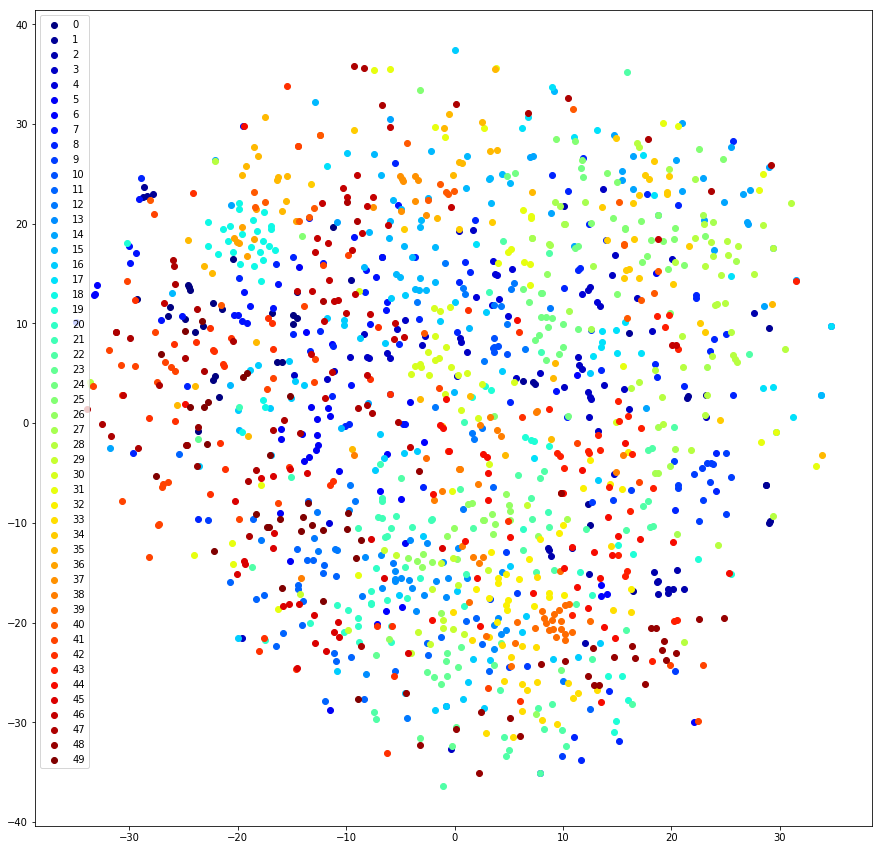

In [10]:
joke_part_vectors = vectorizer.fit(joke_part)

tsne = TSNE(n_components=2, random_state=42, metric='cosine')
xy = tsne.fit_transform(joke_part_vectors)

x=xy[:, 0]
y=xy[:, 1]
classes = labels_part
unique = list(set(classes))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
plt.figure(figsize=(15, 15))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend()

plt.show()

отобразим только раздеимые кластеры

In [28]:
def plot_several_clusters(cluster_list, portion=0.01):
    sub = jokes[jokes.cluster_id.apply(lambda x: x in cluster_list)]
    texts = sub.joke_text.values
    joke_part, _, labels_part, _ = train_test_split(texts, sub.cluster_id, train_size = portion, stratify=sub.cluster_id, random_state=42)
    print(joke_part.shape)
    joke_part_vectors = vectorizer.fit(joke_part)

    tsne = TSNE(n_components=2, random_state=42)
    xy = tsne.fit_transform(joke_part_vectors)

    x=xy[:, 0]
    y=xy[:, 1]
    classes = labels_part
    unique = list(set(classes))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    plt.figure(figsize=(15, 15))
    for i, u in enumerate(unique):
        xi = [x[j] for j  in range(len(x)) if classes[j] == u]
        yi = [y[j] for j  in range(len(x)) if classes[j] == u]
        plt.scatter(xi, yi, c=colors[i], label=str(u))
    plt.legend()
    plt.show()

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(1009,)


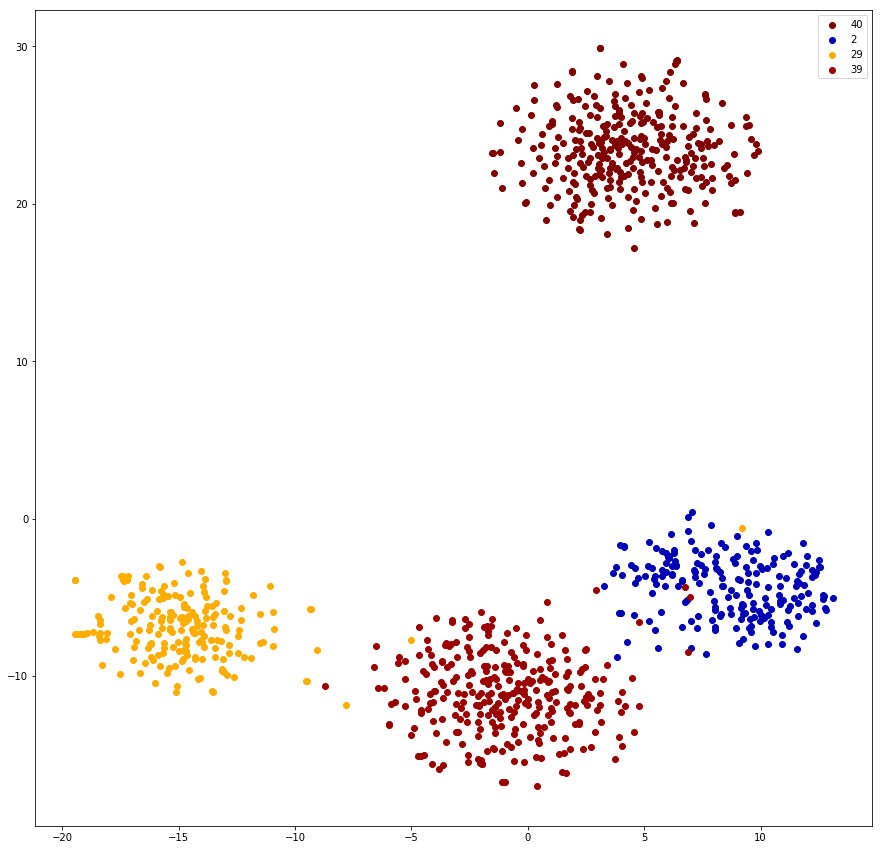

In [29]:
plot_several_clusters([2, 29, 40, 39], portion=0.12)

взять фильтрованные шутки

1) TSNE для того, что есть<br>
2) иерархическая кластеризация для ШУМОВЫХ кластеров<br>
3) используем классификатор на рубрики, смотрим насколько имя кластера соответствует классу, который дал классификатор<br>
4) попробовать разные способы нормализации векторов предложений<br>
5) распределение слова Штирлиц